# Applied Machine Learning 2022 - Assignment 3

### Student: Dimitris Bouris - 8190119

## Is Science Becoming Less Disruptive?

A [recent paper in Nature](https://www.nature.com/articles/s41586-022-05543-x) created a stir in the scientific community, arguing that science is becoming less disruptive over time. According to the study, there are fewer groundbreaking papers in recent years. It appears that trailblazers are rare and that most research tends to build and expand existing research rather than opening up new paths of inquiry.

Needless to say, the paper created quite a bit of head-scratching: if science is becoming less disruptive, what, or who, is to blame? Could it be that the low hanging fruits have already been picked? That modern science requires over-specialisation, which entails working within a field of study, rather than exploring new vistas? The discussion raged even in mainstream media like [The Economist](https://www.economist.com/science-and-technology/2023/01/04/papers-and-patents-are-becoming-less-disruptive), [The New York Times](https://www.nytimes.com/2023/01/17/science/science-breakthroughs-disruption.html), [The Atlantic](https://www.theatlantic.com/newsletters/archive/2023/01/academia-research-scientific-papers-progress/672694/); then Nature returned with an [editorial on what it means and whether it matters](https://www.nature.com/articles/d41586-023-00183-1).

### Question - Predicting CD5

Disruption is measured by a metric, the [CD index](http://russellfunk.org/cdindex/), devised by the authors of the study. The CD is calculated over a time window, say five years (then it's called CD5), and it measures how likely is a work that cites a scientific paper to cite the works *that* paper cites. If follow-up work does not cite a paper's cited predecessors then it's likely that the paper has broken new ground.

The CD index can be calculated for each paper, by finding the works that cite it and the works that the paper itself cites. You can find details in the Nature paper and also in [the original paper that introduced the metric](http://russellfunk.org/cdindex/static/papers/funk_ms_2017.pdf). But then an interesting question arises: is it possible to *predict* a paper's CD5 index by using only the paper itself, information on its authors, and information on its citations, without looking into the future work that cites it?

Your task in this assignment, should you choose to accept it, is to create a Machine Learning model that can predict, as accurately as possible, the CD5 of a published paper.

You must use *at least two* different Machine Learning approaches, one of them employing Neural Networks.

The data that you will use is available [here](https://auebgr.sharepoint.com/:u:/s/AppliedMachineLearning2022/EWYKpAPnCBlItVY4Zyp1Wx4BOroJhlNWZALSpFRsgJEVxA?e=Y3P4Dy) (in MS-Teams, under Class Materials) in the form of an [SQLite](https://www.sqlite.org/) database. It is derived from the excellent [alexandria3k package](https://github.com/dspinellis/alexandria3k) written by [Professor Diomidis Spinellis](https://www2.dmst.aueb.gr/dds/). You can easily find the schema of the data with the standard SQLite facilities and you can also read the [documentation of alexandria3k](https://dspinellis.github.io/alexandria3k/). In particular, the data comprises part of the [publications graph](https://dspinellis.github.io/alexandria3k/cli-eg.html#publications-graph) for a 1% sample of all CrossRef available publications that have abstracts; an additional table in the database contains the CD5 index for papers.

The existence of abstracts in the data is not accidental. As you can see in the Nature paper, the authors make a nod towards identifying text features that are related to how disruptive a paper is; you know enough, from the material we have covered, to try to leverage the abstracts for your task.

The data provided is a minimum; if you wish to use more data, contact the course instructor.

**- In order to succesfully run the notebook the `publications_graph.db` file has to be in the same directory as this notebook**

**- In total, the notebook takes 8 minutes to run**

## Problem Definition

As noted above, the CD index aims to capture the disruption level of a publication. By default the metric is caclulated using information before the papers publication (past), information about the published paper itself (present) and information about the citations of the paper (future). <br>

The key factors which influence the metric are:
- the authors
- the subjects
- the papers referenced
- the number of citations the publication obtains from other papers

Our goal in this assignment is to create a model to succesfully predict the CD index of a publication by expoliting only information about the paper itself (present) and the papers that it references (past). Using future information is forbidden.

## Facts to point out

- The sample provided (1% of total) might lead to biased metrics and models
- The models below might not perform well when trained on the whole dataset as they have been tweaked to fit on current data

## Solution

The initial approach on this problem will be to try to leverage all the metrics that can arise from the paper itself and its citations (ex authors, subjects...). <br>

The second approach would be to caclucate mertics and extract features from the title and the abstract of each publication and then combine them with the initial metrics.

We will start with an overview of the data. The dataset was provided in the form of an SQLIte database so we will use the `sqlite3` library to make data extractions.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import langid
import re

In order to understand the structure of the data, we will use `sqlite3` commands to get the database schema. <br>
In total we have 6 tables.
- `works`
- `work_references`
- `author_affiliations`
- `work_subjects`
- `work_authors`
- `cdindex`

We can see the full `alexandria3k` package database schema [here](https://dspinellis.github.io/alexandria3k/schema.html) in order to understand the relationships between the tables

In [2]:
# Connect to the database
conn = sqlite3.connect('publications_graph.db')

# Create a cursor to execute SQL commands
cursor = conn.cursor()

# Get the schema of the database
cursor.execute("SELECT sql FROM sqlite_master WHERE type='table';")

# Fetch all the rows in the result set
schema = cursor.fetchall()

# Print the schema
for table in schema:
    print(table[0])

CREATE TABLE works(
id,
published_month,
abstract,
title,
published_day,
doi,
published_year
)
CREATE TABLE work_references(
article_title,
year,
work_id,
doi
)
CREATE TABLE author_affiliations(
author_id,
name
)
CREATE TABLE work_subjects(
work_id,
name
)
CREATE TABLE work_authors(
id,
work_id,
orcid
)
CREATE TABLE cdindex(doi, cdindex)


As the unzipped size of the database is approximately 5GB, we will try to get an overview of each table's rows and columns and thus try to read only the data needed.

- Notice that the table `cdindex` contains 116 mil lines.
- This table contains the CD5 indexes foreach work (publication) and the unique identifier is the `doi`.
- Based on the above schema, we will proceed by reading only the cdindex value for the publications in the `works` table.

In [3]:
# create a cursor to iterate over the tables
cursor.execute("SELECT name from sqlite_master where type='table';")
tables = cursor.fetchall()
# iterate over each table and get the name and number of rows
for table in tables:
    table_name = table[0]
    print("Table:", table_name)
    cursor.execute(f"SELECT count(*) from {table_name};")
    num_rows = cursor.fetchall()
    print("Number of rows: ", num_rows[0])

Table: works
Number of rows:  (149078,)
Table: work_references
Number of rows:  (2852181,)
Table: author_affiliations
Number of rows:  (327646,)
Table: work_subjects
Number of rows:  (234357,)
Table: work_authors
Number of rows:  (577214,)
Table: cdindex
Number of rows:  (116568934,)


We can now read all the tables from the database using simple SQL queries.

In [4]:
# read the works table 
works = pd.read_sql_query("SELECT * FROM works;", conn)
# read the work references
work_ref = pd.read_sql_query("SELECT * FROM work_references;", conn)
# read the cd index table
cdindex = pd.read_sql_query("SELECT * FROM cdindex WHERE doi IN (SELECT doi FROM works);", conn)
# read the subjects table
subjects = pd.read_sql_query("SELECT * FROM work_subjects;", conn)
# read the authors table
work_authors = pd.read_sql_query("SELECT * FROM work_authors;", conn)
# read the author affiliations table
author_afill = pd.read_sql_query("SELECT * FROM author_affiliations;", conn)

**We proceed with a quick overview of each table.** <br>
1. Table `works`
- contains info about each publication
- every work is uniquely identified by the `id` or the `doi` attribute
- we also have the title and the abstract for each paper
- the columns `published_month` and `published_day` have many missing values

In [5]:
works.sample(5)

,id,published_month,abstract,title,published_day,doi,published_year
34763,951396,4.0,<jats:p>Only 3%–5% of all brain metastases are...,A Review of the Clinical Outcomes for Patients...,11.0,10.1155/2013/652895,2013.0
49352,1542322,10.0,<jats:p>Equation (2) in the paper by J. Th. Ve...,Method's of Conducting Ships' Speed Trials,NaN,10.1017/s0373463300027946,1953.0
44776,1348199,11.0,<jats:p>Синтезированы гибридные нанокомпозитны...,Получение и сравнительный анализ свойств полим...,NaN,10.36236/1999-1590-2019-11-3-125-129,2019.0
8353,168517,11.0,<jats:title>Abstract</jats:title>\n ...,Growth arrest and terminal differentiation of ...,1.0,10.1182/blood.v84.9.3095.3095,1994.0
78444,2575927,4.0,<p>The first chapter opens with scenes from Ch...,Negro Distrust of the Police Increased,22.0,10.5149/northcarolina/9781469649597.003.0003,2019.0


In [6]:
print("Total number of works: ",works['id'].nunique())

Total number of works:  149078


In [7]:
print("Number of na values in the published_month column: ", sum(works['published_month'].isna()) )
print("Number of na values in the published_day column: ", sum(works['published_day'].isna()) )

Number of na values in the published_month column:  15644
Number of na values in the published_day column:  42271


2. Table `work_references`
- contains info about the references a publication makes to other publications
- we are also provided with the title and the publication year of the referenced papers

In [8]:
work_ref.sample(5)

,article_title,year,work_id,doi
519244,None,None,823275,10.1111/1477-4658.00266
53285,None,None,98355,None
383455,None,2007,577884,None
1843141,None,2017,3049165,10.1186/s12917-017-1180-7
2779527,Uncertainties and limitations in measuring ε a...,1999,4327485,10.1175/1520-0426(1999)016<1483:ualima>2.0.co;2


Notice that we have many missing values in both columns `article_title` and `year`

In [9]:
print("Number of missing values in the article_title column: ", sum(work_ref['article_title'].isna()))
print("Number of missing values in the year column: ", sum(work_ref['year'].isna()))

Number of missing values in the article_title column:  2311266
Number of missing values in the year column:  1585474


Also, the `year` column does not only contain numerical (year) values

In [10]:
work_ref['year'].unique()

array([None, '1987', '1988', ..., '1992d', '1992c', '1999–2000'],
      dtype=object)

3. Table `author_affiliations`
- contains data about the affiliations an author belongs
- one author can have multiple affiliations

In [11]:
author_afill.sample(5)

,author_id,name
142094,29843259392,Bhabha Atomic Research Centre
272126,59630419971,"Clinic of Cardiology, St. Olavs University Hos..."
196196,42695737353,Instituto de Química
289881,62599675905,"School of Computer Engineering, Chengdu Techno..."
279367,61225287684,University of Florida Shands Children’s Hospit...


4. Table `work_subjects`
- contains the descriptions of the subjects a work belongs
- a work can have multiple subjects

In [12]:
subjects.sample(5)

,work_id,name
48945,707140,Reproductive Medicine
136045,2592252,Linguistics and Language
78173,1295406,General Materials Science
24234,197639,Nephrology
215977,4000488,Spectroscopy


5. Table `work_authors`
- contains author names and the corresponding work ids
- the `id` is a database incremental and does not uniquely identify the author
- the unique identifier is the `orcid` for which there are many missing values as we see later on

In [13]:
work_authors.sample(5)

,id,work_id,orcid
430858,55033757696,3358994,None
307490,43797070089,2673161,None
141945,18299781122,1116930,None
332615,47257403393,2884363,None
447501,56972820487,3477345,None


6. Table `cdindex`
- contains a CD5 index for each paper
- the work here is provided with the `doi` unique identifier
- Notice that we also have some `nan` values for the `cdindex` of some papers

In [14]:
cdindex.sample(5)

,doi,cdindex
69259,10.1136/bjo.2008.146381,-0.093023
92268,10.1590/1678-4162-9209,-0.001410
90996,10.5604/01.3001.0013.3079,NaN
111015,10.18224/hab.v13.1.2015.5-30,NaN
92222,10.1152/ajpendo.90425.2008,-0.010309


### Data Cleaning

- first of all, we will keep works for which we have info about their `cdindex`
- as the cdindex table contains `nan` values, we apply the filtering after we drop them

In [15]:
cdindex.dropna(inplace=True)
works = works[works['doi'].isin(cdindex['doi'])]
work_ref['work_id'].nunique(), works['id'].nunique()

(73376, 80281)

Based on the definition of the CD5 index and the way it is calculated, it is not correct to deal with papers which have been published within the 5 past years as their CD5 index cannot be properly calculated ("The CD is calculated over a time window, say five years then it's called CD5"). <br> 

So, for the stake of this analysis, we will keep papers with publication date before 2017.

In [16]:
works = works[works['published_year'] <= 2017]
work_ref['work_id'].nunique(), works['id'].nunique()

(73376, 48422)

- we also notice that the titles and abstracts are in multiple different languages
- this will create problems in any nlp task so we decide to keep only those in english
- we will use the `langid` library to identify the language of each paper based on the abstract

In [17]:
works['abstract'].sample(10)

47378     <jats:title>Abstract</jats:title>\n           ...
36838     <jats:p>Effective implementation of services f...
80617     <jats:p>In todays economy, Chemical Engineeri...
35211     <jats:title>Abstract</jats:title>\n           ...
79313     <jats:p>For a (molecular) graph, the first Zag...
39021     <jats:p>Abstract. Since the advent of Computer...
94639     <jats:title>ABSTRACT</jats:title>\n          <...
86191     <jats:p>As one of the principal failures, duct...
16386     <jats:p> Ni , Zn , Pd and Pt tetra(pentafluoro...
124811    <jats:p>The availability of methods for on-lin...
Name: abstract, dtype: object

- we also notice that the papers abstracts and titles have xml tags in them
- we will remove them as they might affect the language identification

In [18]:
works['abstract'][0]

'<jats:title>Abstract</jats:title><jats:p>The photolysis of dilute solutions of octacyclosulphur or hexacyclosulphur in n-hexane with 253.6\xa0nm UV radiation produces S and possibly S<jats:sub>2</jats:sub>. The ‘ring-opening’ yields of these sulphur molecules range from 0.2 to 0.7. When the hydrogen end-capped polyyne C<jats:sub>10</jats:sub>H<jats:sub>2</jats:sub> is irradiated in n-hexane, it transforms into unidentified products with a quantum yield of 3×10<jats:sup>−5</jats:sup>. When octacyclosulphur is added to the solution, the yield rises to 7×10<jats:sup>−3</jats:sup>. The putative sulphur-bearing product(s) could not be identified. It is suggested that sulphur-bearing molecules might be formed in astronomical settings by reactions of carbon molecules having triple or double C—C bonds with photolytically produced S and/or S<jats:sub>2</jats:sub>.</jats:p>'

In [19]:
works['title'][0]

'On photolytic synthesis of sulphur-bearing organic molecules by reacting S or S<sub>2</sub> with the hydrogen end-capped polyyne C<sub>10</sub>H<sub>2</sub>'

In [20]:
# remove the jets titles and the text inside them using a regex
def remove_xml_tags(text):
    return re.sub("<.*?>", " ", text)

# remove xml tags from both the title and abstract
works["abstract"] = works["abstract"].apply(remove_xml_tags)
works["title"] = works["title"].apply(remove_xml_tags)

- we use the `classify` method of the `langid` library and keep the language which has the biggest probability
- the function takes approximately 3 mins to run so in order to save some time, a `.csv` file has been created with the language of each work.

In [21]:
# works['lang'] = works['abstract'].apply(langid.classify)
# works['lang'] = works['lang'].apply(lambda x: x[0])

# read the csv containing the languages
work_lang = pd.read_csv('data/work_languages.csv')
works = pd.merge(works, work_lang, on='id')
# filter out abstracts which are not written in english
works = works[works['lang']=='en']

After the initial cleaning steps, we can check the `cdindex` distribution.
- most of the works have cdindex around 0 or 1
- we have little or no works which have a `cdindex < -0.25` 
- we have little or no works which have a `0.25 < cdindex < 0.75` 

**Our data seem to be heavily skweed and imbalanced.** For this reason, from now on, we will avoid removing values from our dataset and try to use data imputation techniques.

Text(0.5, 1.0, 'CD5 Distribution')

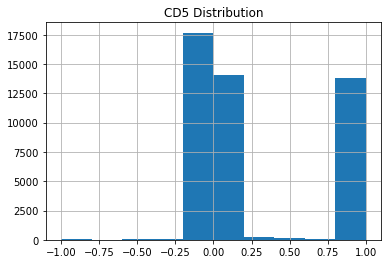

In [22]:
pd.merge(works, cdindex, on='doi')['cdindex'].hist()
plt.title("CD5 Distribution")

### Initial simple metrics for each work
1. mean publication year of the papers cited
2. standard deviation of the publication year of the papers cited
2. number of authors per paper
3. number of references each paper makes
4. number of subjects

1. **Average age of the papers cited - standard deviation of the publication year of the work cited**

To get the publication year of the cited papers, we will use the `year` column in the `work_ref` table. We notice that the column is not well formated. <br>
The column contains values like:
- "2017a"
- "28, 2019."
- "1901–04"
- "1955/1908"
- "1992 (2009)"
- "1972–1973"
- "In press"
- "1945–51"
- "2005 [1998]"
- "2006, Fall"
- "2011;35(10):1308–1317'"

We will use regular expressions to keep as many year values as we can.
- notice that some columns contain 2 year values. In this case, one value represents the original and the other the publication date. We will try to keep the original value (min).
- also, some year values may also contain page values so we try to filter them.

In [23]:
# convert the year values to string format
work_ref['year'] = work_ref['year'].astype('str')
work_ref['year'].unique()

array(['None', '1987', '1988', ..., '1992d', '1992c', '1999–2000'],
      dtype=object)

In [24]:
# replace the string 'None' with nan 
work_ref['year'] = work_ref['year'].replace('None', np.nan)
# find all the numbers with 4 digits
work_ref['year_clean'] = work_ref['year'].str.findall(r'(\d{4})')
# remove some wrong numbers
work_ref['year_clean'] = work_ref['year_clean'].dropna().apply(lambda x: [val for val in x if float(val) <= 2023])
work_ref['year_clean'] = work_ref['year_clean'].dropna().apply(lambda x: [val for val in x if float(val) >= 1940])
# fill with nan paper for which we ended with no years
work_ref['year_clean'] = work_ref['year_clean'].dropna().apply(lambda x: x if len(x) > 0 else np.nan)
# in the case of more than one year, keep the mininum one
work_ref['year_final'] = work_ref['year_clean'].dropna().apply(min)
# convert to type float
work_ref['year_final'] = work_ref['year_final'].astype('float')

In [25]:
# get the mean year of the referenced papers
works_ref_year = work_ref.groupby(by='work_id')['year_final'].mean().to_frame("mean_age")

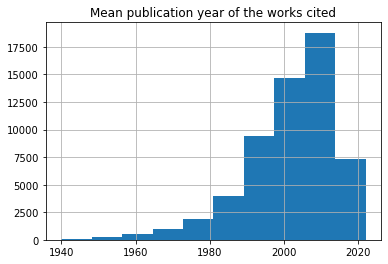

In [26]:
works_ref_year.hist()
_ = plt.title("Mean publication year of the works cited")

We will also calculate the standard deviation of the publication year of the referenced papers

In [27]:
# get the std of the year of the referenced papers
works_ref_year_std =  work_ref.groupby(by='work_id')['year_final'].std().to_frame("ref_year_std")

2. **Number of authors per paper**

In [28]:
work_num_authors = work_authors.groupby('work_id').size().to_frame("num_authors")

- notice that we have some outliers here
- we filter out some data using the 0.98 `quantile()` function

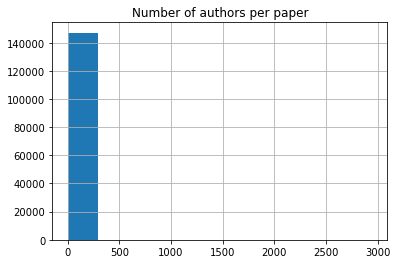

In [29]:
work_num_authors.hist()
_ = plt.title("Number of authors per paper")

After the outlier removal, the distribution looks better

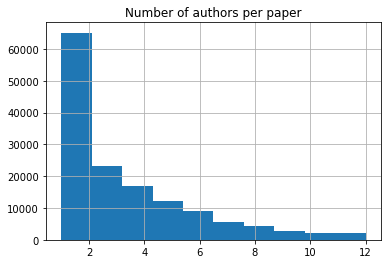

In [30]:
# remove some outliers
work_num_authors = work_num_authors[work_num_authors['num_authors'] < work_num_authors['num_authors'].quantile(0.98)]
work_num_authors.hist()
_ = plt.title("Number of authors per paper")

3. **Number of references a paper makes**

In [31]:
work_num_references = work_ref.groupby(by='work_id')['doi'].count().to_frame("num_references")

- again, we have some outliers which will be removed as above

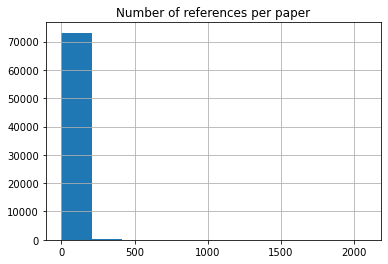

In [32]:
work_num_references.hist()
_ = plt.title("Number of references per paper")

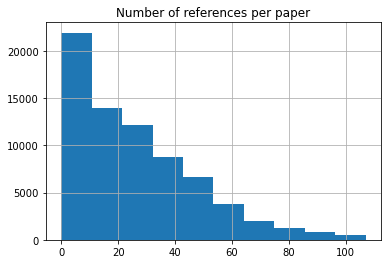

In [33]:
# remove the outliers
work_num_references = work_num_references[work_num_references['num_references'] < work_num_references['num_references'].quantile(0.98)]
work_num_references.hist()
_ = plt.title("Number of references per paper")

4. **Number of subjects per paper**

In [34]:
# calculate the number of subjects each paper references
work_num_subjects = subjects.groupby(by='work_id').size().to_frame("num_subjects")

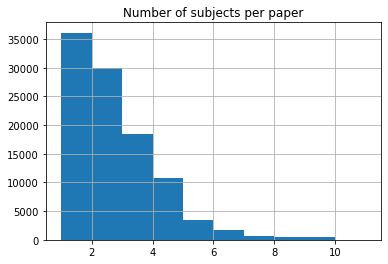

In [35]:
work_num_subjects.hist()
_ = plt.title("Number of subjects per paper")

We will use the metrics calculated up to now to create a regression model and check the proportion of the variance of the `cdindex` variable explained by them.

- We merge the metrics to the fact data using the `id` (work-id)
- We use the left merge in order to avoid droping rows from our imbalanced sample
    - because of the imbalanced dataset, we try to keep the most of our sample
- `nan` values are filled with the `mean()` value of each metric
- instead of using the average publication year of the papers cited, we use the average age of the papers cited by subtracting the value from the `publication_year`of the work
- some of the values of the metric `mean_references_age` were negative so we replace them with `nan` and then fill them with the mean to avoid dropping them

In [36]:
fact_data = works.copy()
fact_data.drop(columns=['doi', 'published_month', 'title', 'abstract', 'published_day', 'lang'], inplace=True)
cdindex_work = pd.merge(works.loc[:,['doi','id']], cdindex, on='doi')
fact_data = pd.merge(fact_data, cdindex_work.loc[:,['id', 'cdindex']], on='id')
fact_data.set_index('id', inplace=True)

# number of subjects
fact_data = pd.merge(fact_data, work_num_subjects, left_index=True, right_index=True, how='left')
# number of authors
fact_data = pd.merge(fact_data, work_num_authors, left_index=True, right_index=True, how='left')
# number of references
fact_data = pd.merge(fact_data, work_num_references, left_index=True, right_index=True, how='left')
# the mean age of the referenced papers
fact_data = pd.merge(fact_data, works_ref_year, left_index=True, right_index=True, how='left')
fact_data['mean_references_age'] = fact_data['published_year'] - fact_data['mean_age']
fact_data.drop(columns='mean_age', inplace=True)
# the age variance of the referenced papers
fact_data = pd.merge(fact_data, works_ref_year_std, left_index=True, right_index=True, how='left')
# replace the negative ages with nan
fact_data['mean_references_age'] = fact_data['mean_references_age'].mask(fact_data['mean_references_age'] < 0, np.nan)

# fill the nan values with the mean of each metric
fact_data['num_subjects'] = fact_data['num_subjects'].fillna(fact_data['num_subjects'].mean())
fact_data['num_authors'] = fact_data['num_authors'].fillna(fact_data['num_authors'].mean())
fact_data['num_references'] = fact_data['num_references'].fillna(fact_data['num_references'].mean())
fact_data['mean_references_age'] = fact_data['mean_references_age'].fillna(fact_data['mean_references_age'].mean())
fact_data['ref_year_std'] = fact_data['ref_year_std'].fillna(fact_data['ref_year_std'].mean())

fact_data.drop(columns='published_year', inplace=True)
fact_data.describe()

,cdindex,num_subjects,num_authors,num_references,mean_references_age,ref_year_std
count,46164.000000,46164.000000,46164.000000,46164.000000,46164.000000,46164.000000
mean,0.299760,2.325664,3.594685,23.468839,11.827446,8.389787
std,0.461007,1.278080,2.379164,16.616962,5.593484,3.719458
min,-1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,-0.002168,1.000000,2.000000,12.000000,9.500000,7.366652
50%,0.000000,2.000000,3.000000,23.468839,11.827446,8.389787
75%,1.000000,3.000000,5.000000,27.000000,11.827446,8.389787
max,1.000000,11.000000,12.000000,107.000000,77.000000,46.669048


The data imbalance persits
- we expect that the model will not perform well when predicting `cdindex` values for which we have little training data

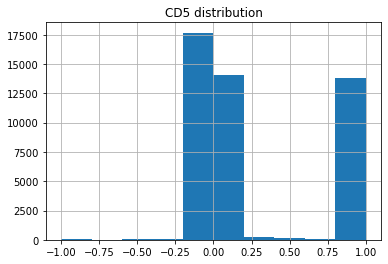

In [37]:
fact_data['cdindex'].hist()
_ = plt.title("CD5 distribution")

We then create a training and test dataset using the `train_test_split` from `sklearn`. We keep 30% of the data for testing purposes.

In [38]:
from sklearn.model_selection import train_test_split
# split the features from the dependent variable
cols_to_keep = fact_data.columns.difference(['cdindex'])
X = fact_data.loc[:,cols_to_keep]
y = fact_data['cdindex']
# create a train and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

We will use the xgb regressor from the `xgb` library.
- xgb works well on skewed datasets
- can identify non-linear relationships
- our evaluation metrics will be the `mean_absolute_error`, `mean_squared_error` and the $R^2$ score on the test data

In [39]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

- we train the model with the optimal `max_depth`, `n_estimators` and `learning_rate` parameters on our datatset to also avoid overfitting
- we check for overfitting by comparing the $R^2$ score on the training and test dataset


Parameters Used:
- `max_depth` : This parameter specifies the maximum depth of each tree in the XGBoost model. Increasing the value of max_depth makes the model more complex and allows it to learn more intricate relationships between the features and the target variable. However, setting this parameter too high can lead to overfitting.
- `n_estimators` : This parameter specifies the number of trees in the XGBoost model. Increasing the value of n_estimators can improve the model's accuracy, but at the cost of increased computational time and memory usage.
- `learning_rate` : This parameter controls the step size used during the gradient descent process in the XGBoost model. A smaller learning rate makes the model converge more slowly but can lead to better generalization performance. A larger learning rate allows the model to converge more quickly, but can lead to overfitting.

The optimal parameter combination was identified through the `sklearn.model_selection.GridSearchCV` which enables the exhaustive search over specified parameter values for an estimator. 

In [40]:
xgb_reg = xgb.XGBRegressor(max_depth=4, n_estimators=200, learning_rate=0.1)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

- at first glance, our model performs exceptionaly well 
- `mean_absolute_error` and `mean_squared_error` are very low (0.02 and 0.01 respectively)
- $R^2$ score is very high (96%) meaning that our variables explain the 96% of the variance of the dependent `cdindex`

In [41]:
# get the predictions on the testing dataset
preds = xgb_reg.predict(X_test)

# calculate the evaluation metrics
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

# print the results
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2 Score (Training): {xgb_reg.score(X_train, y_train):.2f}")
print(f"R2 Score (Test): {r2:.2f}")

MAE: 0.02
MSE: 0.01
R2 Score (Training): 0.97
R2 Score (Test): 0.96


But if we plot the predicted values in comparisson to the actual ones the results do not seem that promising. We expect the dots to gather around the diagonal red line but the reality is different.
- the model performs well for `cdindex` values around 0 and 1
    - those were the values for which we had a lot of training data
- for all the other `cdindex` values, the model predicts 0 which is wrong
- what causes this problem is our sample! The model has little or no sample to train on those `cdindex` values so it is expected that it also fails to predict them

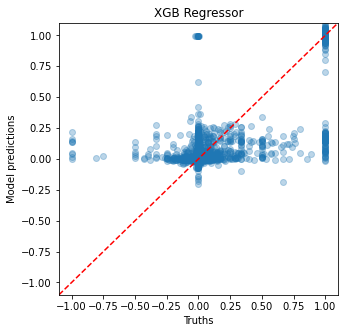

In [42]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, preds, alpha=0.3)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.title("XGB Regressor")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([-1.1, 1.1])
_ = plt.ylim([-1.1, 1.1])

**Fact:** Although the Truth vs Predictions plot is not that good, the $R^2$ metric is exceptionally high. This happens because of the fact that the values that the model fails to predict account for a very small percentage of the total sample and thus do not affect the `mean_absolute_error` and `mean_squared_error` metrics.

Below we can also see the feature importances with the number of references being the most influential factor.

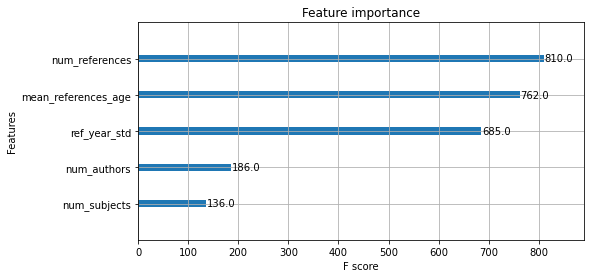

In [43]:
fig = plt.figure(figsize=(8, 4))
_ = xgb.plot_importance(xgb_reg, ax = fig.gca())

### Feature Extraction 

We continue by leveraging the title and the abstract of each paper using nlp techniques to extract features which further explain the variation of the `cdindex`. We will also exploit the author affiliations and the subject titles.

**1. Differentiation in Subjects**


- As noted above, one work usually references more than one subjects.
- The subjects represent the topic of the paper.
- Our target with this metric is to find how different subjects that a paper references are.
- We do that by comparing their titles and more specifically their vocabulary.
- A high value in this metric indicates that the subjects referenced have high differentiation.
- A low value in this metric indicates that the subjects referenced are similar to each other.

Example: Lets say that a paper references the subjects sub1:"Computer Science" and sub2:"Computer Vision". Those subjects are quite similar. The metric will identify that they have a word in common ("Computer") and thus return a low value .
On the other hand, if a paper references the subjects sub1:"Nature" and sub2:"Neural Networks" the metric, accounting for the number of different words between them will return a high value.

In [44]:
# read the subjects table
subjects = pd.read_sql_query("SELECT * FROM work_subjects;", conn)
subjects = pd.merge(subjects, cdindex_work, left_on='work_id', right_on='id')

we merge all the subject names for each paper to a single string to perform the word counts

In [45]:
merged_subjects = subjects.groupby(by='work_id')['name'].apply(' '.join).reset_index()
merged_subjects = pd.merge(merged_subjects, cdindex_work, left_on='work_id', right_on='id')

In order to improve the accuracy of our calculations on the text, we will implement a preprocessing step. More specifically:
- all words are converted to lowercase
- each sentence is being split to words and saved in a list 
- all the numerical characters are removed
- all the words that are less than three characters long are being removed
- words are stemmed and lemmatized 


*Stemming and lemmatization are both techniques used in natural language processing (NLP) to normalize words and reduce their inflected forms to their base or dictionary form (ex running --> run).* We use the `nltk` library and the functions `WordNetLemmatizer()` and the `PorterStemmer()` to perform this task.

In [46]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Define a function to tokenize the words in a sentence
def tokenize_words(sentence):
    # tokenize each word
    tokens = word_tokenize(sentence.lower())
    # remove numeric characters 
    tokens = [token for token in tokens if not re.match(r'^-?\d+\.\d+|-?\d+$', token)]
    # remove words with less than 3 characters
    tokens = [token for token in tokens if len(token) >=3]
    # lemmatize
    lemmas = [lemmatizer.lemmatize(token, pos='n') for token in tokens]
    # perform stemming
    stemmed_words = [stemmer.stem(word) for word in lemmas]
    return stemmed_words


# Apply the tokenize_words function to the 'name' column of the dataframe
merged_subjects['name'] = merged_subjects['name'].apply(tokenize_words)

After the preprocessing step, we can add all the words in a dictionary and also create a corpus which we will then use to make the calculations needed.

In [47]:
from gensim.corpora import Dictionary
# create the dictionary
dictionary_subjects = Dictionary(merged_subjects['name'])
# create the corpus
corpus_subjects = [ dictionary_subjects.doc2bow(doc) for doc in merged_subjects['name']]

Then, we iterate over the corpus and calculate the `total_words` and the `unique_words` per papers subjects and finaly the `unique_ratio` as the division of those two.

In [48]:
# unique to total words ratio 
word_counts = []

# Loop through each document in the corpus
for doc in corpus_subjects:
    # Compute the total word count for the document by summing the word counts
    total_words = sum(count for _, count in doc)
    unique_words = len(doc)
    # Compute the ratio of unique words to total words
    unique_ratio = unique_words / total_words
    # Append the total word count for the document to the word_counts list
    word_counts.append(unique_ratio)
word_counts = pd.Series(word_counts,name='subject_word_variation')

The results are then saved in a dataframe which has the `id` (work_id) as index.

In [49]:
num_subjects = subjects.groupby(by='work_id').size().to_frame('num_subjects').reset_index()

p = pd.concat([merged_subjects, word_counts], axis=1)
p.set_index('work_id', inplace=True)
p = p['subject_word_variation']

But there is a problem with the current implementation of the metric. 

- Imagine that a paper references a single subject only
- The metric will most likely return 100% as the probability of the words in the title of the single subject to be different is high.
- This way, the differentiation we want is not captured in a correct way 
- Taking into account the realization above, we will proceed to alleviating this effect by multiplying the metric we calculated with the  value `number of subjects of the paper` / `max number of subjects`

Thus, a paper with a single subject and inital metric 100%, after the modification would get a value of 100% * 1/12 = 0.08 indicating a low differentiation (supposing that the max number of subjects is 12). 

In [50]:
# merge the metric calculated for each paper with the number of subjects the paper references
v = pd.merge(p, num_subjects, left_index=True, right_on='work_id')
# calculate the new metric
v ['subjects_differentiation'] = v['subject_word_variation'] * (v['num_subjects'] / v['num_subjects'].max())
v.set_index('work_id', inplace=True)

- for most papers, the subject differentiation is low meaning that they mostly reference similar subjects

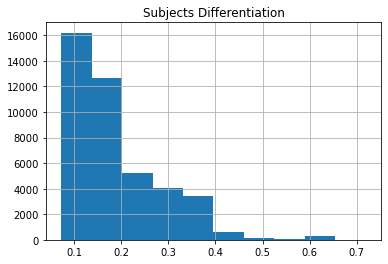

In [51]:
v['subjects_differentiation'].hist()
_ = plt.title("Subjects Differentiation")

**2. Number of subjects introduced**

This metric aims to count how many of the subjects a paper references have not been referenced before, meaning that the publication introduces a new subject category. For example, the paper that introduced the subject "Quantum computing" was firstly introduced by a publication in 1980 and before that the term did not exist as a category. <br>

We expect that a paper which introduces subjects has a higher probability of being disruptive than a paper which uses pre-existing subjects. <br>

This metric however would perform better when calculated on the whole publications graph. When used in a small proportion of the whole dataset, the metric identifies papers which have introduced many subjects but we cannot be sure that those subjects have not been introduced by another publication which is not included in our sample.

Firstly, we set the year that each subject was introduced as the mininum publication year of the papers that reference it

In [52]:
subjects_year = pd.merge(works, subjects, left_on='id', right_on='id')
year_introduction = subjects_year.groupby(by='name')['published_year'].min().to_frame("year_introduction")

We assume that a paper introduces a subject when the introduction year of the subject we calculated above is equal to the publication year of the paper. <br>

To more accurately define this metric we could use a more precise comparison technique by exploiting the month and day other than the year, but due to missing values in our dataset, this was not possible.

In [53]:
subjects_year = pd.merge(subjects_year, year_introduction, right_index=True, left_on='name')
subjects_year['same_Year'] = subjects_year.apply(lambda row: 1 if row['published_year'] == row['year_introduction'] else 0, axis=1)

In [54]:
# calculate the total number of subjects introduced per paper
subjects_introduced = subjects_year.groupby('id')['same_Year'].sum().to_frame("subjects_introduced")
num_subjects.set_index('work_id', inplace=True)
subjects_introduced = pd.merge(subjects_introduced, num_subjects['num_subjects'], left_index=True, right_index=True)
# weigh the above metric with the total number of subjects a paper references
subjects_introduced['subjects_introduced'] = subjects_introduced['subjects_introduced'] / subjects_introduced['num_subjects']

- Notice that most papers do not seem to introduce any new subject (0% of their subjects are newly intoduced)
- Only a small proportion of the works has a 100% new subjects.

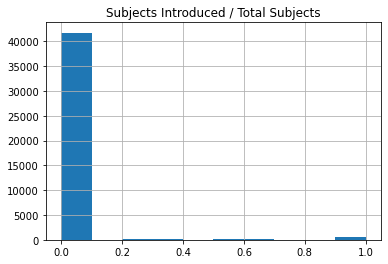

In [55]:
subjects_introduced['subjects_introduced'].hist()
_ = plt.title("Subjects Introduced / Total Subjects")

**3. Age of the subjects combination**

This metric finds for each paper the age of the subjects combination it references. <br>

- a low value in this metric indicates that the combination is new
- whereas a high value indicates that the combination is relatively aged

Example: A paper published in 2010 references the subjects "Neural Networks", "Computing" and "Data Analytics". Lets say that the first paper including the exact same combination of subjects was published in 2006. The metric will return 2010-2006 = 4 years.

**Note:** As we explained above about the metric "Number of subjects introduced", for the exact same reasons this metric would also be more accurate when implemented on the whole publications graph.

Firstly, we group by the work_id to get the subjects per paper and then we create a sorted tuple out of them.

In [56]:
subject_tuples = subjects_year.loc[:,['id', 'name', 'published_year']]
# create a sorted tuple to make sure that all the permutations of the same combination are captured
subject_tuples = subject_tuples.groupby(by='id')['name'].apply(lambda x: tuple(sorted(x))).to_frame("combination").reset_index()
subject_tuples = pd.merge(subject_tuples, works.loc[:,['id', 'published_year']], on='id')

Then, we identify the year that the combination first appears in a publication.

In [57]:
year_comb_introduced = subject_tuples.groupby(by='combination')['published_year'].min().to_frame("year_comb_introduced").reset_index()

Finally, for each paper, we subtract the year that the combination was introduced from the publication year of the paper.

In [58]:
subject_tuples = pd.merge(subject_tuples, year_comb_introduced, on='combination')
subject_tuples['age_of_subject_comb'] = subject_tuples['published_year'] - subject_tuples['year_comb_introduced']
age_of_comb = subject_tuples.loc[:,['id', 'age_of_subject_comb']]
age_of_comb.set_index('id', inplace=True)

- Most papers reference subject combinations which are new

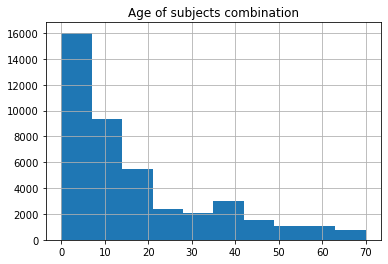

In [59]:
age_of_comb.hist()
_ = plt.title("Age of subjects combination")

**4. Number of previous similar publications**

This metric counts how many publications existed with the same subject combination before the works publication (year). In a more precise implementation of the metric, we could calcuate the number of publications before the exact publication date of the paper (year-month-day) but unfortunately our dataset had many missing values on those attributes.
- if the metric is high, it indicates that there have been lots of papers with those subject combination
- whereas if the metric is low, the discussion around the subjects was limited before the works publication

At first, we count the number of publications per combination and year.

In [60]:
papers_before = subject_tuples.groupby(['combination', 'published_year']).size().to_frame("num_papers").reset_index()

Then, for each combination, we calculate the number of papers "up to this" year as the rolling sum of the years before.

In [61]:
papers_before['papers_before'] = papers_before.groupby(['combination'])['num_papers'] \
    .transform(lambda x: x.shift().rolling(len(x), 1).sum())

Finally, we merge the above results with the works.

In [62]:
papers_before =  pd.merge(subject_tuples.loc[:,['id', 'combination','published_year']], \
                          papers_before, on=['combination', 'published_year'])
papers_before.fillna(0, inplace=True)

In [63]:
papers_before.drop(columns=['combination', 'published_year', 'num_papers'], inplace=True)
papers_before.set_index('id', inplace=True)

- The interesting fact here is that most of the papers reference subject combinations for which there are no other previous publications

**Note:** As with other metrics, this calculation would be more precise when used on the whole dataset.

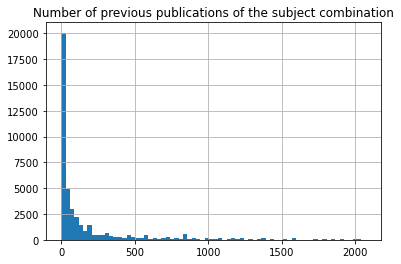

In [64]:
papers_before.hist(bins=70)
_ = plt.title("Number of previous publications of the subject combination")

**5. Number of words per title and abstract**

As a first implementation of the NLP techniques on the titles and abstracts we calculate their size in words. 

In [65]:
text = works.loc[:,['doi','id','abstract', 'title']]

In [66]:
text = pd.merge(text, cdindex, on='doi')
text.reset_index(drop=True, inplace=True)

again, we will use a similar approach when preprocessing and tokenizing the words (both for abstracts and titles) as we did with subjects

In [67]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer



lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Define a function to tokenize the words in a sentence
def tokenize_words(sentence):
    # tokenize the words
    tokens = word_tokenize(sentence.lower())
    # remove numeric values
    tokens = [token for token in tokens if not re.match(r'^-?\d+\.\d+|-?\d+$', token)]
    # keep words with more than 3 characters
    tokens = [token for token in tokens if len(token) >=3]
    # lemmatize 
    lemmas = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    # tokenize 
    stemmed_words = [stemmer.stem(word) for word in lemmas]
    return stemmed_words


# Apply the tokenize_words function to the 'abstract' and 'title' column of the dataframe
text['abstract'] = text['abstract'].apply(tokenize_words)
text['title'] = text['title'].apply(tokenize_words)

this time, we also filter out words that appear in less than 10% or more than 50% of the documents.

In [68]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary_abstracts = Dictionary(text['abstract'])
dictionary_titles = Dictionary(text['title'])
# filter out some outliers
dictionary_abstracts.filter_extremes(no_below=0.1, no_above=0.5)
dictionary_titles.filter_extremes(no_below=0.1, no_above=0.5)

In [69]:
# create a corpus for both the abstracts and titles
corpus_abstracts = [ dictionary_abstracts.doc2bow(doc) for doc in text['abstract']]
corpus_titles = [ dictionary_abstracts.doc2bow(doc) for doc in text['title']]

Then, we can count the words for each abstract and title

In [70]:
# Word count for abstracts
word_counts = []

# Loop through each document in the corpus
for doc in corpus_abstracts:
    # Compute the total word count for the document by summing the word counts
    total_words = sum(count for _, count in doc)
    # Append the total word count for the document to the word_counts list
    word_counts.append(total_words)
word_counts = pd.Series(word_counts,name='word_count_abstract')
text = pd.concat([text, word_counts], axis=1)

In [71]:
# word count for titles
word_counts = []

# Loop through each document in the corpus
for doc in corpus_titles:
    # Compute the total word count for the document by summing the word counts
    total_words = sum(count for _, count in doc)
    # Append the total word count for the document to the word_counts list
    word_counts.append(total_words)
word_counts = pd.Series(word_counts,name='word_count_titles')
text = pd.concat([text, word_counts], axis=1)

- notice that there are papers with titles and abstracts with no words left inside
- we will drop them

In [72]:
text['word_count_abstract'].min(), text['word_count_titles'].min()

(0, 0)

In [73]:
# remove papers with no characters in the abstract and title 
text = text[(text['word_count_abstract'] != 0) & ((text['word_count_titles'] != 0))]
text.reset_index(drop=True, inplace=True)
# create the new corpuses
corpus_abstracts = [ dictionary_abstracts.doc2bow(doc) for doc in text['abstract']]
corpus_titles = [ dictionary_abstracts.doc2bow(doc) for doc in text['title']]

In [74]:
text.sample(5)

,doi,id,abstract,title,cdindex,word_count_abstract,word_count_titles
27475,10.5194/acp-2016-281,2394582,"[abstract, estim, the, amount, methan, ch4, em...","[methan, emiss, from, dairi, the, lo, angel, b...",1.000000,145,7
37601,10.1115/1.2896124,3425065,"[the, invers, dynam, robot, manipul, base, fle...","[invers, dynam, flexibl, robot, arm, model, an...",1.000000,68,9
27534,10.1177/1087054716646449,2395934,"[object, thi, studi, investig, the, relationsh...","[the, relationship, between, parent, affect, t...",-0.000033,103,12
22625,10.1177/088740349200600105,1820299,"[the, variou, method, select, state, trial, co...","[account, independ, myth, judici, select]",0.000000,54,5
10989,10.3141/1898-04,755200,"[agent-bas, travel, demand, model, develop, wh...","[agent-bas, approach, travel, demand, model, e...",0.000000,129,7


We can see the min, max and average size of the titles and abstracts below.

In [75]:
# describe both series
desc1 = text['word_count_abstract'].describe()
desc2 = text['word_count_titles'].describe()

# concatenate into a single table
result = pd.concat([desc1, desc2], axis=1)
result.columns = ['Word Count Abstract', 'Word Count Title']
result

,Word Count Abstract,Word Count Title
count,46040.000000,46040.000000
mean,107.108666,8.272242
std,56.061818,3.486382
min,1.000000,1.000000
25%,68.000000,6.000000
50%,102.000000,8.000000
75%,141.000000,10.000000
max,1413.000000,72.000000


**6. Type-token ratio per abstract**

This metric aims to identify the diversity of words used in each abstract. We divide the number of unique words appearing in the abstract by the total number of words. We expect that a revolutionary and disruptive publication would need a diverse vocabulary to express the new idea in contrary to a non disruptive paper. <br>
- high type-token ratio indicate great diversity
- low type-token ratio indicate less diversity

Note: We could apply this metric to the titles too but the small number of words would always lead to a high value.

In [76]:
# unique to total words ratio 
word_counts = []

# Loop through each document in the corpus
for doc in corpus_abstracts:
    # Compute the total word count for the document by summing the word counts
    total_words = sum(count for _, count in doc)
    unique_words = len(doc)
    # Compute the ratio of unique words to total words
    unique_ratio = unique_words / total_words
    # Append the total word count for the document to the word_counts list
    word_counts.append(unique_ratio)
word_counts = pd.Series(word_counts,name='word_ratio_abstract')
text = pd.concat([text, word_counts], axis=1)
text.set_index('id', inplace=True)

- Papers with high diversity in their vocabulary are limited
- Most of them have a type-token ratio around 0.7

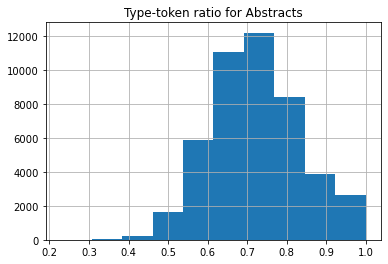

In [77]:
text['word_ratio_abstract'].hist()
_ = plt.title("Type-token ratio for Abstracts")

**7. Words indicating new or improvement in abstracts**

We expect that a disruptive publication would contain more verbs evoking creation, discovery or perception than a publication which builds on top of other works. We also expect that publications improving existing works would mostly contain verbs indicating improvement, application or assesment. <br>

We will count the occurrence of those two clusters of words inside each abstract and create a single metric by subtracting those counts. <br>
- a positive value means that the words evoking new outweigh the words indicating improvement 
- a negative value means that the words indicating improvement outweigh the words evoking new
- a zero value means that none of the two word clusters stands out

The choice to only count verbs is not rational. Verbs have an intertemporal meaning in the vocabulary in contrast to nouns and adjectives which may represent special terminology and thus counting them would lead to using future information.

Example: An abstract contains 7 words evoking creation and 3 words indicating improvement. Our metric would be 7-3=4 > 0

In [78]:
# we will use the preprocessed abstracts we created above
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(text['abstract'])
corpus = [dictionary.doc2bow(doc) for doc in text['abstract']]

We will search for the words below:

The verbs `develop` , `design`, `present`, `structure`, `form`, `provide`, `increase`, `introduce` indicate creation and new. <br>

On the other hand the verbs `improve`, `enhance`, `increase`, `use`, `include`, `associate`, `mediate`, `assess` evoke improvement of existing works.

The selection of those words was based on modern grammar and the Supplementary info of the Nature publication ("Papers and patents are becoming less disruptive over time")

In [79]:
# the list below contains the stemmed and lemamtized form of the verbs indicating new
words_indicating_new = ['develop', 'design', 'present', 'structur', 'form', 'provid', 'increas', 'introduc']
words_indicating_new_counts = []
for i in range(len(corpus)):
    # count the occurence of each word in the above list in each document
    word_count = sum([freq for (word_id, freq) in corpus[i] if dictionary[word_id] in words_indicating_new])
    words_indicating_new_counts.append(word_count)
word_counts_new = pd.Series(words_indicating_new_counts,name='words_new')

In [80]:
# the list below contains the stemmed and lemamtized form of the verbs evoking improvement
words_indicating_improvment = ['improv', 'enhanc', 'increas', 'use', 'includ', 'associ', 'mediat', 'assess']
words_indicating_improvment_counts = []
for i in range(len(corpus)):
    # count the occurence of each word in the above list in each document
    word_count = sum([freq for (word_id, freq) in corpus[i] if dictionary[word_id] in words_indicating_improvment])
    words_indicating_improvment_counts.append(word_count)
word_counts_improv = pd.Series(words_indicating_improvment_counts,name='words_improve')

Finally, we subtract the two counts to get the metric

In [81]:
text.reset_index(inplace=True)
text = pd.concat([text, word_counts_new], axis=1)
text = pd.concat([text, word_counts_improv], axis=1)
# subtract the words indicating new from the ones indicating improvement
text['new/improv'] = text['words_new'] - text['words_improve']
text.drop(columns=['words_new', 'words_improve'], inplace=True)
text.set_index('id', inplace=True)

Most papers seem to be neutral meaning that neither the words indicating new nor the ones idicating improvement stand out

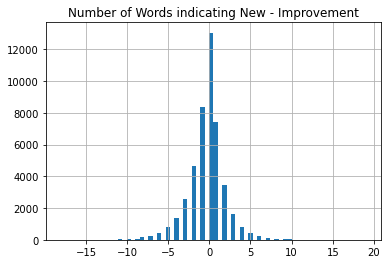

In [82]:
text['new/improv'].hist(bins=70)
_ = plt.title("Number of Words indicating New - Improvement")

**8. Differentiation in the author affiliations**

This metric aims to exploit the different "titles" (affiliations) of the authors of a publication to find how similar they are. In general, an author affiliation might contain an institution name, a department or division and the city and country. So looking for differences in the words will indicate the level of similarity.

The core idea behind this metric is similar to the "Subject Differentiation" calculated above.

- We will use word comparing again.
- A high value in this metric indicates that the authors have differences between them
- A low value in this metric indicates that the authors have a lot in common

In [83]:
work_authors_afill  = pd.merge(work_authors, author_afill, left_on='id', right_on='author_id')

some affiliations contain `\n` characters so we remove them.

In [84]:
af = work_authors_afill.loc[:,['work_id', 'name']]
af.dropna(inplace=True)
# replace \n character with " "
af['name'] = af['name'].str.replace(r'\n', ' ')

/var/folders/v7/cd7r3hf1229b9tnytv_qr8hm0000gn/T/ipykernel_23878/971487264.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  af['name'] = af['name'].str.replace(r'\n', ' ')


exactly as we did with subjects, we continue with merging all the affiliation names per work in a single string

In [85]:
af = af.groupby(by='work_id')['name'].apply(' '.join).reset_index()
af.head(5)

,work_id,name
0,239,"Styperson House Adlington, Macclesfield, Chesh..."
1,299,"Biomolecular Science Center, University of Cen..."
2,373,"Technische Universität Dresden, Institute of M..."
3,471,"Portsmouth Polytechnic, Department of Geology ..."
4,517,"Applied Geology Ltd., Thorburn Associates Camd..."


we implement nlp preprocessing methods too

In [86]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Define a function to tokenize the words in a sentence
def tokenize_words(sentence):
    # lower all the words and tokenize the sentence
    tokens = word_tokenize(sentence.lower())
    # remove numeric characters
    tokens = [token for token in tokens if not re.match(r'^-?\d+\.\d+|-?\d+$', token)]
    # remove words with less than 3 characters
    tokens = [token for token in tokens if len(token) >=3]
    # lemmatize
    lemmas = [lemmatizer.lemmatize(token, pos='n') for token in tokens]
    # stemm the words
    stemmed_words = [stemmer.stem(word) for word in lemmas]
    return stemmed_words


# Apply the tokenize_words function to the 'name' column of the dataframe
af['name'] = af['name'].apply(tokenize_words)

In [87]:
from gensim.corpora import Dictionary
# create the dictionary
dictionary_afill = Dictionary(af['name'])
# create the corpus
corpus_afill = [dictionary_subjects.doc2bow(doc) for doc in af['name']]

In [88]:
# word count for titles
word_counts = []

# Loop through each document in the corpus
for doc in corpus_afill:
    # Compute the total word count for the document by summing the word counts
    total_words = sum(count for _, count in doc)
    # Append the total word count for the document to the word_counts list
    word_counts.append(total_words)
word_counts = pd.Series(word_counts,name='word_count_affil')
af = pd.concat([af, word_counts], axis=1)

there are some affiliation strings which do not contain any words after the tokenization, so we remove them

In [89]:
# remove papers with no characters in the affiliations
af = af[af['word_count_affil'] != 0]
af.reset_index(drop=True, inplace=True)

# create the new dictionary and corpus
dictionary_afill = Dictionary(af['name'])
corpus_afill = [ dictionary_afill.doc2bow(doc) for doc in af['name']]

In [90]:
# unique to total words ratio 
word_counts = []

# Loop through each document in the corpus
for doc in corpus_afill:
    # Compute the total word count for the document by summing the word counts
    total_words = sum(count for _, count in doc)
    unique_words = len(doc)
    # Compute the ratio of unique words to total words
    unique_ratio = unique_words / total_words
    # Append the total word count for the document to the word_counts list
    word_counts.append(unique_ratio)
word_counts = pd.Series(word_counts,name='affil_ratio')
af = pd.concat([af, word_counts], axis=1)

finally, we save the results in a dataframe

In [91]:
balance_factor = af['word_count_affil'].min() / af['word_count_affil'].max()
af = af.loc[:,['work_id', 'affil_ratio']]
af['affil_ratio'] = af['affil_ratio']
af.set_index('work_id', inplace=True)

- For most papers, the type-token ratio in the affiliations is low indicating that the paper authors usually have similar affiliations and thus similar characteristics
- There are also some papers with a high author affiliation differentiation

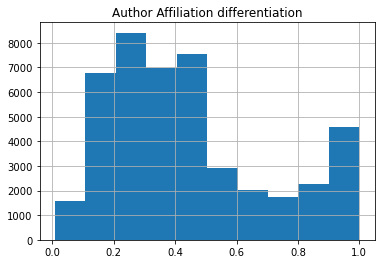

In [92]:
af.hist()
_ = plt.title("Author Affiliation differentiation")

- After having used nlp techniques to extract features from the text, we can proceed to creating a new regression model to ultimately predict the `cdindex` more precisely
- We will use the same `XGBRegressor()` as we did above but also include some of the new metrics created

We start by creating the fact table and merging all the features. The features we will add are the following:


- number of subjects
- number of authors
- number of references
- type-token ratio abstract
- word count title 
- subjects variation
- age of subject combination
- count of words indicating new and improvement
- mean age of referenced papers
    - we calculate that by subtracting the mean references publication year from the work publication year
- standard deviation of the publication year of the referenced papers


**Importnant Note:** The metrics added to this model are the best ones based on the current dataset. In the event of a more balanced and complete dataset, another feature combination could perform better meaning that some of the variables we calculated before which were not included (ex number of similar publications) could help our model be more precise with another dataset.

In [93]:
fact_data = works.copy()
fact_data.drop(columns=['doi', 'published_month', 'title', 'abstract', 'published_day', 'lang'], inplace=True)
cdindex_work = pd.merge(works.loc[:,['doi','id']], cdindex, on='doi')
fact_data = pd.merge(fact_data, cdindex_work.loc[:,['id', 'cdindex']], on='id')
fact_data.set_index('id', inplace=True)

# number of subjects
fact_data = pd.merge(fact_data, work_num_subjects, left_index=True, right_index=True, how='left')
# number of authors
fact_data = pd.merge(fact_data, work_num_authors, left_index=True, right_index=True, how='left')
# number of references
fact_data = pd.merge(fact_data, work_num_references, left_index=True, right_index=True, how='left')
# token ratio per paper
fact_data = pd.merge(fact_data, text['word_ratio_abstract'], left_index=True, right_index=True)
# size of title
fact_data = pd.merge(fact_data, text['word_count_titles'], left_index=True, right_index=True)
# word_ratio subjects
fact_data = pd.merge(fact_data, v['subjects_differentiation'], left_index=True, right_index=True)
# age of combination
fact_data = pd.merge(fact_data, age_of_comb, left_index=True, right_index=True)
# new - improve words
fact_data = pd.merge(fact_data, text['new/improv'], left_index=True, right_index=True, how='left')
# the mean age of the referenced papers
fact_data = pd.merge(fact_data, works_ref_year, left_index=True, right_index=True, how='left')
fact_data['mean_references_age'] = fact_data['published_year'] - fact_data['mean_age']
fact_data.drop(columns='mean_age', inplace=True)
# the age standard deviation of the referenced papers
fact_data = pd.merge(fact_data, works_ref_year_std, left_index=True, right_index=True, how='left')


fact_data.drop(columns=['published_year'], inplace=True)

# replace negative references_age values with nan to then fill them with the mean
fact_data['mean_references_age'] = fact_data['mean_references_age'].mask(fact_data['mean_references_age'] < 0, np.nan)

# fill nan values with the mean of each metric
fact_data['num_subjects'] = fact_data['num_subjects'].fillna(fact_data['num_subjects'].mean())
fact_data['num_authors'] = fact_data['num_authors'].fillna(fact_data['num_authors'].mean())
fact_data['num_references'] = fact_data['num_references'].fillna(fact_data['num_references'].mean())
fact_data['mean_references_age'] = fact_data['mean_references_age'].fillna(fact_data['mean_references_age'].mean())
fact_data['ref_year_std'] = fact_data['ref_year_std'].fillna(fact_data['ref_year_std'].mean())

# fact_data['affil_ratio'] = fact_data['affil_ratio'].fillna(fact_data['affil_ratio'].mean())
fact_data['new/improv'] = fact_data['new/improv'].fillna(fact_data['new/improv'].mean())

Then, we create the train and test dataset.

In [94]:
# split the features from the dependent variable
cols_to_keep = fact_data.columns.difference(['cdindex'])
X = fact_data.loc[:,cols_to_keep]
y = fact_data['cdindex']

# create a train and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

- From the correlation heat map below we can see that there are no serious feature multicolinearity problems
- The mean references age and the references publication year std have a high correlation (0.63) which is expected, but removing one of them from the model drops its accuracy

<AxesSubplot:>

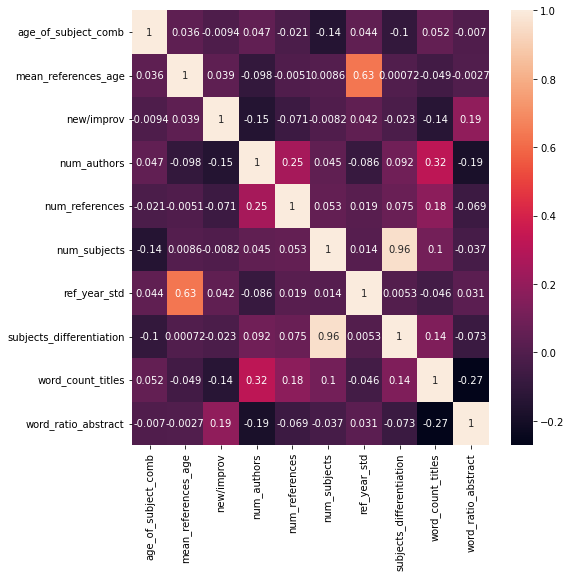

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_mat = X.corr()
plt.figure(figsize=(8,8))
sns.heatmap(correlation_mat, annot = True)

We can now create and fit our model.

In [96]:
xgb_reg = xgb.XGBRegressor(max_depth=4, n_estimators=200, learning_rate=0.1, objective='reg:squarederror',
                          booster='gbtree')

xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

- Based on the metrics below, our model looks similar to the model in our initial approach
- `mean_absolute_error`, `mean_squared_error` and $R^2$ (Test) are identical
- There is no sign of overfitting as the testing and training $R^2$ are similar

In [97]:
# make predictions on the test dataset
preds = xgb_reg.predict(X_test)

# calculate the evaluation metrics
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

# print the results
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2 (Test): {r2:.2f}")
print(f"R2 (Train): {xgb_reg.score(X_train, y_train):.2f}")

MAE: 0.02
MSE: 0.01
R2 (Test): 0.96
R2 (Train): 0.97


Comparing now the true and predicted values of our testing dataset we conclude to the following:
- the plot has little or no differences to our initial approach
- the model performs well in the `cdindex` areas where we have enough sample data (0 and 1)
- the model makes inaccurate predictions for `cdindex` areas with little or no sample
- the data imbalance affects it heavily

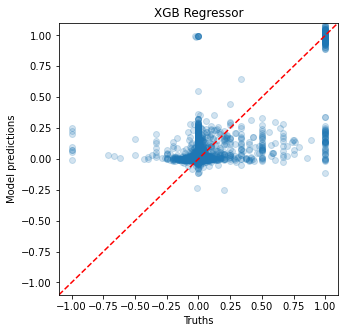

In [98]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, preds, alpha=0.2)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.title("XGB Regressor")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([-1.1, 1.1])
_ = plt.ylim([-1.1, 1.1])

**Fact:** Although the Truths vs Predictions plot is not that good, the $R^2$ metric is exceptionally high. This happens because of the fact that the values that the model fails to predict account for a very small percentage of the total sample and thus do not affect the `mean_absolute_error` and `mean_squared_error` metrics.

**Feature Importances:**
- by far the most improtant feature in predicting the `cdindex` turns out to be the number of references
- the publication year standard deviation and the mean references age also contribute enough
- the importance of the number of authors and subjects is low compared to the other features

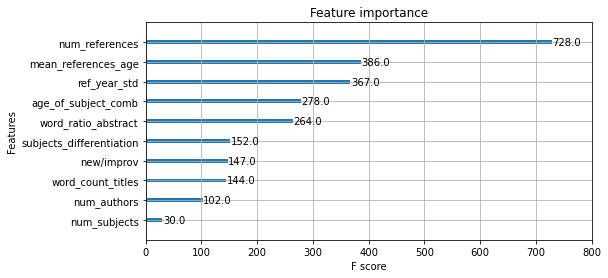

In [99]:
fig = plt.figure(figsize=(8, 4))
_ = xgb.plot_importance(xgb_reg, ax = fig.gca())

We make another attempt by implementing another model. We will use the `RandomForestRegressor`, a decission tree based regressor similar to the xgb.

In [100]:
from sklearn.ensemble import RandomForestRegressor

# create a random forest regressor with multiple trees
rf = RandomForestRegressor(n_estimators=5000,max_depth=5,n_jobs=-1)

# fit the regressor to the training data
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=5000, n_jobs=-1)

After training our model, we use the test dataset to acess it.

- `mean_absolute_error`, `mean_squared_error` and $R^2$ (Test) are identical to the xgb approach
- there is no sign of overfitting as the test and training $R^2$ are similar

In [101]:
# make predictions on the test dataset
preds = rf.predict(X_test)

# calculate the evaluation metrics
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

# print the results
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2 (Test): {r2:.2f}")
print(f"R2 (Train): {rf.score(X_train, y_train):.2f}")

MAE: 0.02
MSE: 0.01
R2 (Test): 0.96
R2 (Train): 0.96


- the random forest regressor seems to be more accurate when predicting `cdindex` values around 0 than the xgb
- When the true value of the `cdindex` is 0, our model returns a value ranging from 0 to 0.25 (excluding some outliers) whereas the xgb model returns values from -0.1 to 0.3 

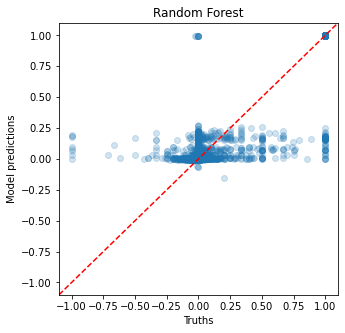

In [102]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, preds, alpha=0.2)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red", )
plt.title("Random Forest")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([-1.1, 1.1])
_ = plt.ylim([-1.1, 1.1])

Quite interesting is the fact that the feature importances for those two models (which have been trained on the same dataset) are significantly different. Both models highlight the importance of the number of references factor but the random forest regressor does not account for any other feature except for the mean references age. <br>

It is not surprising that the two models assign different levels of importance to the same features, as they may be prioritizing different aspects of the data and use different techniques on calculating them.

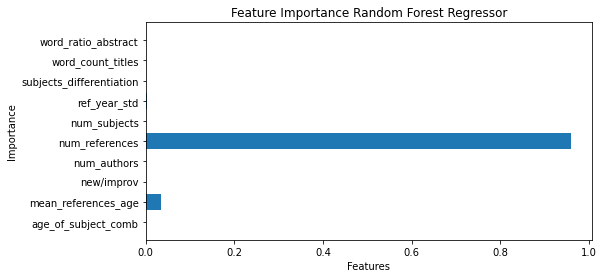

In [103]:
fig = plt.figure(figsize=(8, 4))
_ = plt.barh(range(len(rf.feature_importances_)), rf.feature_importances_)
_ = plt.yticks(range(len(rf.feature_importances_)), X_train.columns)
_ = plt.xlabel("Features")
_ = plt.ylabel("Importance")
_ = plt.title("Feature Importance Random Forest Regressor")
plt.show()

Overall, despite some small differences in the predictions and the feature importances, both models had a similar performance.

### Lets now use a neural network on the same problem

The features that we will use are the following:

- number of subjects
- number of references
- number of authors
- references age
- standard deviation of the references publication year

Those were the features that performed the best in our current dataset

In [104]:
fact_data = works.copy()
fact_data.drop(columns=['doi', 'published_month', 'title', 'abstract', 'published_day', 'lang'], inplace=True)
cdindex_work = pd.merge(works.loc[:,['doi','id']], cdindex, on='doi')
fact_data = pd.merge(fact_data, cdindex_work.loc[:,['id', 'cdindex']], on='id')
fact_data.set_index('id', inplace=True)

# number of subjects
fact_data = pd.merge(fact_data, work_num_subjects, left_index=True, right_index=True, how='left')
# number of authors
fact_data = pd.merge(fact_data, work_num_authors, left_index=True, right_index=True, how='left')
# number of references
fact_data = pd.merge(fact_data, work_num_references, left_index=True, right_index=True, how='left')
# the mean age of the referenced papers
fact_data = pd.merge(fact_data, works_ref_year, left_index=True, right_index=True, how='left')
fact_data['mean_references_age'] = fact_data['published_year'] - fact_data['mean_age']
fact_data.drop(columns='mean_age', inplace=True)
# the age variance of the referenced papers
fact_data = pd.merge(fact_data, works_ref_year_std, left_index=True, right_index=True, how='left')

fact_data.drop(columns=['published_year'], inplace=True)

# replace the negative values with nan in order to fill them with the mean
fact_data['mean_references_age'] = fact_data['mean_references_age'].mask(fact_data['mean_references_age'] < 0, np.nan)
# fill na values with the mean of each metric
fact_data['num_subjects'] = fact_data['num_subjects'].fillna(fact_data['num_subjects'].mean())
fact_data['num_authors'] = fact_data['num_authors'].fillna(fact_data['num_authors'].mean())
fact_data['num_references'] = fact_data['num_references'].fillna(fact_data['num_references'].mean())
fact_data['mean_references_age'] = fact_data['mean_references_age'].fillna(fact_data['mean_references_age'].mean())
fact_data['ref_year_std'] = fact_data['ref_year_std'].fillna(fact_data['ref_year_std'].mean())

In [105]:
fact_data.describe()

,cdindex,num_subjects,num_authors,num_references,mean_references_age,ref_year_std
count,46164.000000,46164.000000,46164.000000,46164.000000,46164.000000,46164.000000
mean,0.299760,2.325664,3.594685,23.468839,11.827446,8.389787
std,0.461007,1.278080,2.379164,16.616962,5.593484,3.719458
min,-1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,-0.002168,1.000000,2.000000,12.000000,9.500000,7.366652
50%,0.000000,2.000000,3.000000,23.468839,11.827446,8.389787
75%,1.000000,3.000000,5.000000,27.000000,11.827446,8.389787
max,1.000000,11.000000,12.000000,107.000000,77.000000,46.669048


**Importnant Note:** The metrics added to this neural network are the best ones based on the current dataset. In the event of a more balanced and complete dataset, another feature combination could perform better meaning that some of the variables we calculated before which were not included (ex nlp on abstracts and titles) could help our model be more precise with another dataset.

We proceed by creating a training and test dataset.

In [106]:
# split the data into the features and the dependent variable
cols_to_keep = fact_data.columns.difference(['cdindex'])
X = fact_data.loc[:,cols_to_keep]
y = fact_data['cdindex']

# create the training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

- we import the libraries and packages needed to train a neural network using `tensorflow`
- we also set the seed value for the random number generators of three different libraries: NumPy, Python's built-in `random` library, and TensorFlow to grant reproducibility

In [107]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import random

np.random.seed(0)
random.seed(48) 
tf.random.set_seed(48)
tf.keras.utils.set_random_seed(48)

Our neural network will consist of 4 total layers (1 input, 2 hidden and 1 output)
- the first layer will be a Normalization one as it improves convergence speed, increasing generalization performance, and reduces the likelihood of overfitting
- the next 2 (Dense) hidden layers will have 64 neurons each and `relu` as the activation function
- the last - output layer will have a single neuron as we need a single output from the network (regression problem predicting a continuous variable)

- notice that we use `adapt` for the Normalization layer to get to know the mean, variance and count of the dataset
- the Normalizer adapts only on the train dataset as we can then ensure that the model is not influenced by the testing data

In [108]:
# adapt the normalization layer on the train dataset
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
with np.printoptions(precision=2):
    print(normalizer.mean)
    print(normalizer.variance)
    print(normalizer.count)

2023-02-26 19:39:48.809207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf.Tensor([[11.82  3.59 23.44  2.32  8.39]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 31.33   5.64 275.9    1.65  13.88]], shape=(1, 5), dtype=float32)
<tf.Variable 'count:0' shape=() dtype=int64, numpy=32314>


We can then produce the network 
- as we have a regression problem implemented in the neural network, we use the `mean_squared_error` as a loss function 
- we also use the adam optimizer with 0.001 learning rate

In [109]:
initializer = tf.keras.initializers.GlorotUniform(seed=42)
# specify the architecture of the model 
def build_compile_model():
    model = keras.Sequential([
        normalizer,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    
    return model

model = build_compile_model()

In [110]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


- we train our neural network on the train dataset in 100 epochs
- in each epoch, we keep 20% of the data for validation
- we keep the batch size to default (32)

In [111]:
num_epochs = 100

# fit the model
history = model.fit(
    np.array(X_train), 
    np.array(y_train),
    epochs=num_epochs, 
    validation_split=0.2,
    verbose=1)

Epoch 1/100
808/808 [==============================] - 1s 585us/step - loss: 0.0707 - val_loss: 0.0285
Epoch 2/100
808/808 [==============================] - 0s 509us/step - loss: 0.0282 - val_loss: 0.0223
Epoch 3/100
808/808 [==============================] - 0s 506us/step - loss: 0.0240 - val_loss: 0.0191
Epoch 4/100
808/808 [==============================] - 0s 507us/step - loss: 0.0223 - val_loss: 0.0184
Epoch 5/100
808/808 [==============================] - 0s 508us/step - loss: 0.0210 - val_loss: 0.0169
Epoch 6/100
808/808 [==============================] - 0s 507us/step - loss: 0.0194 - val_loss: 0.0163
Epoch 7/100
808/808 [==============================] - 0s 506us/step - loss: 0.0176 - val_loss: 0.0145
Epoch 8/100
808/808 [==============================] - 0s 505us/step - loss: 0.0161 - val_loss: 0.0150
Epoch 9/100
808/808 [==============================] - 0s 503us/step - loss: 0.0149 - val_loss: 0.0138
Epoch 10/100
808/808 [==============================] - 0s 512us/step - l

Epoch 80/100
808/808 [==============================] - 0s 510us/step - loss: 0.0084 - val_loss: 0.0071
Epoch 81/100
808/808 [==============================] - 0s 508us/step - loss: 0.0084 - val_loss: 0.0071
Epoch 82/100
808/808 [==============================] - 0s 508us/step - loss: 0.0084 - val_loss: 0.0080
Epoch 83/100
808/808 [==============================] - 0s 509us/step - loss: 0.0086 - val_loss: 0.0073
Epoch 84/100
808/808 [==============================] - 0s 508us/step - loss: 0.0083 - val_loss: 0.0080
Epoch 85/100
808/808 [==============================] - 0s 509us/step - loss: 0.0085 - val_loss: 0.0076
Epoch 86/100
808/808 [==============================] - 0s 509us/step - loss: 0.0083 - val_loss: 0.0083
Epoch 87/100
808/808 [==============================] - 0s 510us/step - loss: 0.0082 - val_loss: 0.0076
Epoch 88/100
808/808 [==============================] - 0s 509us/step - loss: 0.0083 - val_loss: 0.0074
Epoch 89/100
808/808 [==============================] - 0s 510us

- to evaluate the network, we use the $R^2$ score and the `mean_squared_error` metric
- the `model.evaluate()` method returns the `mean_squared_error` score. We use this method on the test dataset

- despite the fact that the $R^2$ score is the same as the xgb and random forest models, the `mean_squared_error` metric is significantly smaller
    - 0.008 in the neural network
    - 0.01 in the decission tree models
    
In general, the neural network outperforms the other models.

In [112]:
# make predictions on the test dataset
test_predictions = model.predict(np.array(X_test)).flatten()
# print the evaluation metrics
print("MEAN error: ", model.evaluate(np.array(X_test), np.array(y_test), verbose=0))
print(f"R2 Score: {r2_score(test_predictions, y_test):.2f}")

433/433 [==============================] - 0s 302us/step
MEAN error:  0.008416855707764626
R2 Score: 0.96


Graphicaly, the truth vs predicted values plot looks like the other models. <br>

**Fact:** Although the Truths vs Predictions plot is not that good, the $R^2$ metric is exceptionally high. This happens because of the fact that the values that the model fails to predict account for a very small percentage of the total sample and thus do not affect the `mean_absolute_error` and `mean_squared_error` metrics.

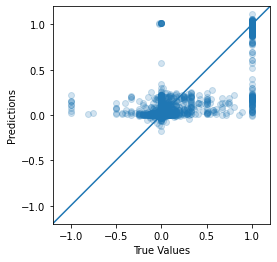

In [113]:
plt.figure(figsize=(4, 4))
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions, alpha=0.2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-1.2, 1.2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

- in order to assess the network in terms of overfitting or underfitting, we create graph showing the loss in training and validation
- to avoid overfitting, the training loss and validation loss should be close to each other and not diverge much
- as we can see in the graph below, the two lines are close to each other and thus the model did not overfit.

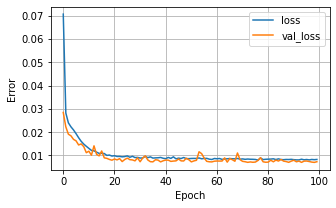

In [114]:
def plot_loss(history):
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
plot_loss(history)

### Turning the regression into a classification problem

As we have seen above, the regression models are heavily affected by the strong data imbalance and perform well only on `cdindex` values for which we have sufficient training data. <br>
We decide to turn the problem into a classification one. For classification problems, there are many popular techniques to perform sample balancing which seems inevitable for our type of problem.

- the first step is to find proper bins and define the classes
- the histogram below shows that most data have a `cdindex` around 0 and 1
- there are also some empty zones (little or no data)
    - (-1 -0.25]
    - (0.25 - 1]
    
**Note:** We will use the same fact table i.e. the same features as we used for the above neural network.

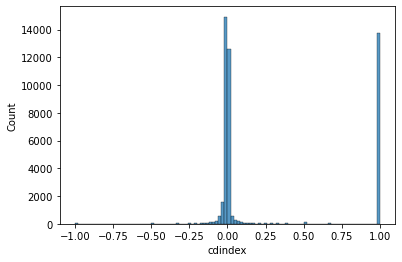

In [115]:
classification_fact_data = fact_data.copy()
_ = sns.histplot(classification_fact_data['cdindex'], bins=100, kde=False)

In [116]:
# calculate the outlier counts
v1 = sum(classification_fact_data['cdindex'] < -0.25)
v2 = sum((classification_fact_data['cdindex'] > 0.25) & (classification_fact_data['cdindex'] < 1))
print("Values below -0.25: ", v1)
print("Values between 0.25 and : 1", v2)

Values below -0.25:  103
Values between 0.25 and : 1 373


- An initial approach could be to create 2 classes. The one would contain the `cdindex` ≈ 0 and the other `cdindex` values ≈ 1
- Although, this approach is very specific to our current dataset
- Ultimately, we decide to split the dataset based on the `cdindex` values in 3 equally sized bins as shown below

In [117]:
pd.cut(classification_fact_data['cdindex'], 3).unique()

[(-0.333, 0.333], (0.333, 1.0], (-1.002, -0.333]]
Categories (3, interval[float64, right]): [(-1.002, -0.333] < (-0.333, 0.333] < (0.333, 1.0]]

In [118]:
classification_fact_data['class'] = pd.cut(fact_data['cdindex'], 3, labels=False)

# create a labels dictionary to rename the classes created
labels = {
    0 : 'low',
    1 : 'medium',
    2 : 'high'
}
classification_fact_data.drop(columns='cdindex', inplace=True)

- After the binning most values belong to the `cdindex` medium class
- The data imbalance persists as we have few data in the low class

<AxesSubplot:>

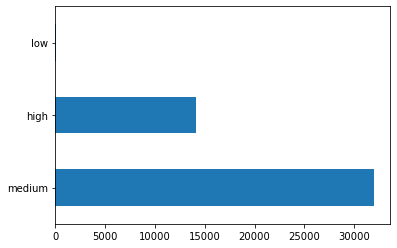

In [119]:
classification_fact_data['class'].map(labels).value_counts().plot.barh()

- As noted above, there are many popular techniques to balance the dataset in a classification problem
- We will use the `SMOTE` oversampler which generates synthetic examples of the minority class by interpolating between the existing examples. It does this by selecting a random minority-class example and then choosing one or more of its nearest neighbors (also minority-class examples).
- The balancing is applied on the train dataset.

In [120]:
# split the independent features from the dependent variable
cols_to_keep = classification_fact_data.columns.difference(['class'])
X = classification_fact_data.loc[:,cols_to_keep]
y = classification_fact_data['class']

# create the training and testing dataset
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y, random_state=42, test_size=0.3)

Notice that after the oversampling all of the 3 classes have equal number of data.

In [121]:
from imblearn.over_sampling import SMOTE

# balance the dataset using the SMOTE oversampling technique
smote_features, smote_labels = SMOTE().fit_resample(X_train_class, y_train_class)
print('Before SMOTE:', np.bincount(y_train_class))
print('After SMOTE:', np.bincount(smote_labels))

Before SMOTE: [   51 22448  9815]
After SMOTE: [22448 22448 22448]


We will train an `XGBClassifier` on our train dataset.

In [122]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

clf = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=5)

# Train the classifier on the training set
clf.fit(smote_features, smote_labels)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

At first sight, the results seem promising as the Accuracy Score on the test dataset is ≈ 98.5%

In [123]:
from sklearn.metrics import accuracy_score

# Make predictions on the test set
y_pred = clf.predict(X_test_class)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test_class, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.42%


Lets define some evaluation metrics for a classification problem first

- Precision: Precision measures the proportion of true positives among the instances that the model predicted as positive. In other words, precision measures how often the model is correct when it predicts a positive label.

- Recall:Recall measures the proportion of true positives among all the instances that are actually positive. In other words, recall measures how often the model correctly identifies positive instances.

- Accuracy: Accuracy measures the proportion of correct predictions among all the instances. In other words, accuracy measures how often the model is correct in predicting both positive and negative labels.

- After asessing the classification report we can conclude to the fact that our model is not that accurate
- Notice that both `precision` and `recall` metrics for class 0 (low) are disappointing
- The model works perfectly for the medium (1) and high (2) class
- Despite the SMOTE balancing technique we applied, the model is not performing well in the (initial) minority class
    - this happens as for the class 0 (low) we have little data meaning that the oversampling technique cannot generate a representative amount of data

In [124]:
cr = classification_report(y_test_class, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.17      0.04      0.07        23
           1       0.98      0.99      0.99      9528
           2       0.99      0.97      0.98      4299

    accuracy                           0.98     13850
   macro avg       0.71      0.67      0.68     13850
weighted avg       0.98      0.98      0.98     13850



Our conclusions are also validated from the confusion matrix

- Out of 23 samples in the 0 (low) class the model correclty identifies only 1 of them. The other 22 are misclassified in class 1 (medium)
- In classes 1 (medium) and 2 (high) the model predicts the overwhelming majority of samples correctly

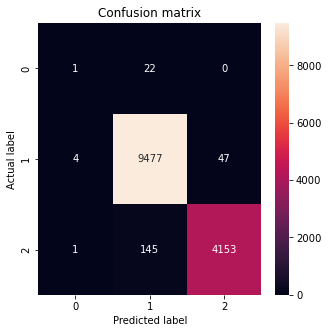

In [125]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    return cm
cm = plot_cm(y_test_class, y_pred)

In the event of having the whole dataset at our disposal, an approach with 5 equal sized bins would be better. The bins split could happen based on the intervals below
- $\left[ -1, -0.6 \right)$
- $\left[ -0.6, -0.2 \right)$
- $\left[ -0.2, 0.2 \right)$
- $\left[ 0.2, 0.6 \right)$
- $\left[ 0.6, 1\right]$



### Word embeddings

We will try to exploit the abstracts in a more in depth way by using word embeddings.

Word embeddings are a type of numerical representation of words in natural language processing (NLP). These embeddings are designed to capture the semantic meaning of words in a language by mapping each word to a high-dimensional vector. Word embeddings are usually learned from large datasets using machine learning algorithms, such as neural networks.

Instead of training a model to find the word embeddings on our datasets vocabulary, we will use a pre-trained model. This approach also helps avoid using future information, as training a model on our dataset and getting the word embeddings for a papers abstract entails using words which have not been used before its publication date (ex special terminology). Also, a pre-trained model saves us a lot of time and effort to get the vectors on our own. On the other hand, a pre-trained model might fail to identify words on which it has not been trained on.

After getting the embeddings vector for each word of each abstract, we will combine this information with the above metrics.

In [126]:
# get the abstracts of the works we will use
to_embed = works.loc[:,['id', 'doi', 'title', 'abstract']]
to_embed = pd.merge(to_embed, cdindex, on='doi')

Our fact table containing the calculated metrics will look like the one we used to train the regression neural network

In [127]:
fact_data = works.copy()
fact_data.drop(columns=['doi', 'published_month', 'title', 'abstract', 'published_day', 'lang'], inplace=True)
cdindex_work = pd.merge(works.loc[:,['doi','id']], cdindex, on='doi')
fact_data = pd.merge(fact_data, cdindex_work.loc[:,['id', 'cdindex']], on='id')
fact_data.set_index('id', inplace=True)

# number of subjects
fact_data = pd.merge(fact_data, work_num_subjects, left_index=True, right_index=True, how='left')
# number of authors
fact_data = pd.merge(fact_data, work_num_authors, left_index=True, right_index=True, how='left')
# number of references
fact_data = pd.merge(fact_data, work_num_references, left_index=True, right_index=True, how='left')
# the mean age of the referenced papers
fact_data = pd.merge(fact_data, works_ref_year, left_index=True, right_index=True, how='left')
fact_data['mean_references_age'] = fact_data['published_year'] - fact_data['mean_age']
fact_data.drop(columns='mean_age', inplace=True)
# the age variance of the referenced papers
fact_data = pd.merge(fact_data, works_ref_year_std, left_index=True, right_index=True, how='left')

# remove values which have a negative mean references age 
fact_data['mean_references_age'] = fact_data['mean_references_age'].mask(fact_data['mean_references_age'] < 0, np.nan)

# fill all the nan values with the mean of the corresponding metric
fact_data['num_subjects'] = fact_data['num_subjects'].fillna(fact_data['num_subjects'].mean())
fact_data['num_authors'] = fact_data['num_authors'].fillna(fact_data['num_authors'].mean())
fact_data['num_references'] = fact_data['num_references'].fillna(fact_data['num_references'].mean())
fact_data['mean_references_age'] = fact_data['mean_references_age'].fillna(fact_data['mean_references_age'].mean())
fact_data['ref_year_std'] = fact_data['ref_year_std'].fillna(fact_data['ref_year_std'].mean())

fact_data.drop(columns=['published_year'], inplace=True)
# fact_data.dropna(inplace=True)

In [128]:
fact_data.describe()

,cdindex,num_subjects,num_authors,num_references,mean_references_age,ref_year_std
count,46164.000000,46164.000000,46164.000000,46164.000000,46164.000000,46164.000000
mean,0.299760,2.325664,3.594685,23.468839,11.827446,8.389787
std,0.461007,1.278080,2.379164,16.616962,5.593484,3.719458
min,-1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,-0.002168,1.000000,2.000000,12.000000,9.500000,7.366652
50%,0.000000,2.000000,3.000000,23.468839,11.827446,8.389787
75%,1.000000,3.000000,5.000000,27.000000,11.827446,8.389787
max,1.000000,11.000000,12.000000,107.000000,77.000000,46.669048


In [129]:
# split the features from the dependent variable
cols_to_keep = fact_data.columns.difference(['cdindex'])
X = fact_data.loc[:,cols_to_keep]
y = fact_data['cdindex']

# create a train and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

As we did with the other NLP tasks, we will preprocess our abstarcts.
- we lower all the words
- remove punctuation and special characters
- remove stop words 
- apply stemming and tokenization

In [130]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

# Download stopwords and initialize stemmer and lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[\W_]+|\w*\d\w*', ' ', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stop words and apply stemming/lemmatization
    processed_tokens = [lemmatizer.lemmatize(stemmer.stem(token)) for token in tokens if token not in stop_words]
    # Join the processed tokens back into a string
    processed_text = ' '.join(processed_tokens)
    return processed_text

to_embed['title'] = to_embed['title'].apply(preprocess)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dimitrisbouris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dimitrisbouris/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We can now load the pretrained model.

- We will use a GloVe (Global Vectors for Word Representation) pre-trained model
- The model has been trained on  datasets from Wikipedia, Common Crawl, and the Gigaword
- We use the 200 dim model meaning that each word will be represented by a 200 dimension matrix 
- We use `gensim` to obtain the model

In [131]:
import gensim.downloader as api

# Load the GloVe embeddings into Python using gensim
glove_vectors = api.load('glove-wiki-gigaword-200')

- as we said, each word is represented by a 200 dimension vector 
- a common way to represent a corpus of words using the embeddings (ie the abstract) is to get create a matrix `(number of words, 200)` containing the embedding for each word in the abstract and then use the mean of each column
    - this way, we have a single 200 dimension representation for each abstract `(1, 200)`
- we will use this implementation

In [132]:
# define a function to return the vector representation for each abstract
def text_to_vector(text):
    words = text.split()
    # we use the model loaded before to get the embedding
    vectors = [glove_vectors[word] for word in words if word in glove_vectors.key_to_index]
    # if we have at least one word identified, we calculate the mean as noted above
    if vectors:
        return np.mean(vectors, axis=0)
    # if we have no words identified, we add a 200 dim zero matri
    else:
        return np.zeros(200)  # Return a zero vector if the text contains no known words

# Convert the abstracts to vectors of word embeddings
X = np.array([text_to_vector(abstract) for abstract in to_embed['abstract']])

In [133]:
# get the dependent variable
y = to_embed['cdindex']

In [134]:
# get the additional features we calculated before
additional_features = fact_data.drop(columns='cdindex')
additional_features.reset_index(inplace=True, drop=True)
# we will concat the embeddings with the other metrics we have calculated
X = pd.concat([pd.DataFrame(X), additional_features], axis=1)

In [135]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [136]:
xgb_reg = xgb.XGBRegressor(max_depth=4, n_estimators=100, learning_rate=0.1)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

The model seems equivalent to all the other models we have tried
- Again, there is no sign of overfitting

In [137]:
# make predictions on the test dataset
preds = xgb_reg.predict(X_test)

# calculate the evaluation metrics
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

# print the results 
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2 (Test): {r2:.2f}")
print(f"R2 (Train): {xgb_reg.score(X_train, y_train):.2f}")

MAE: 0.02
MSE: 0.01
R2 (Test): 0.96
R2 (Train): 0.97


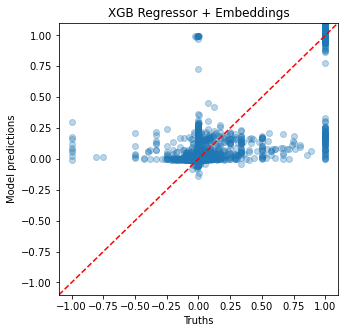

In [138]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, preds, alpha=0.3)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.title("XGB Regressor + Embeddings")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([-1.1, 1.1])
_ = plt.ylim([-1.1, 1.1])

As far as the Feature Importances are concerned:
- the number of references parameter is still the most influencial
- the parameters mean references age and references publication year std are also quite important
- lots of the dimensions of the embeddings seem to have a significant contribution

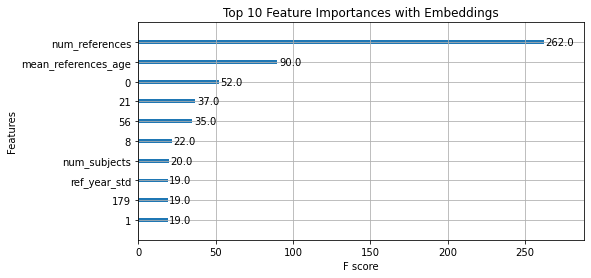

In [139]:
fig = plt.figure(figsize=(8, 4))
_ = xgb.plot_importance(xgb_reg, ax = fig.gca(), max_num_features=10, title='Top 10 Feature Importances with Embeddings')

Overall, adding the embeddings in our model did not help make our predictions more accurate.

## Conclusion

- The imbalance in our dataset created many problems
- Some of the features proposed apprear to be biased beacuse of our sample
- On our dataset, the nlp techniques implemented did not help the model to be more accurate
- The features added to each model are the ones which more accurately predict the `cdindex` based on our dataset which are not necessarily the best ones for a model trained on the whole dataset
- In the case of having the whole dataset, we might need to change both our model parameters and our feature combinations by adding some of the features we calculated and not used.